<a href="https://colab.research.google.com/github/ABDA48/Machine_Learning/blob/main/Tweet_Emotion_Recognition_Learner_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 6.5 MB/s 
     |████████████████████████████████| 212 kB 49.7 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
from sklearn.metrics import confusion_matrix

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.2


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
dataset=nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train=dataset['train']
validation=dataset['validation']
test=dataset['test']

In [ ]:
def get_data(data):
  tweets=[x['text'] for x in data]
  labels=[x['label'] for x in data]
  return tweets,labels

In [ ]:
tweets_train,labels_train=get_data(train)
tweets_val,labels_val=get_data(validation)
tweets_test,labels_test=get_data(test)

## Task 4: Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer(num_words=10000,oov_token='<UNK>')
tokenizer.fit_on_texts(tweets_train)

In [ ]:
tokenizer.texts_to_sequences([tweets_train[0]])

[[2, 139, 3, 679]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

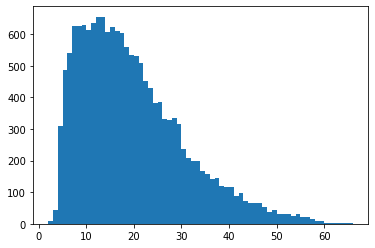

In [ ]:
lengths=[len(t.split(' ')) for t in tweets_train]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [ ]:
maxlen=50
from tensorflow.keras.preprocessing.sequence import pad_sequences
def get_sequences(tokenizer,tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen)
  return padded


In [ ]:
padded_train_seq=get_sequences(tokenizer,tweets_train)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
classes=set(labels_train)
print(classes)

{'sadness', 'anger', 'joy', 'fear', 'surprise', 'love'}


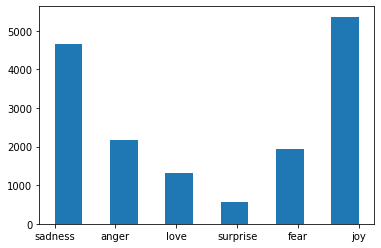

In [ ]:
plt.hist(labels_train,bins=11)
plt.show()

In [ ]:
classes_to_index=dict((c,i)for i,c in enumerate(classes))
index_to_class=dict((v,k) for k,v in classes_to_index.items())

In [ ]:
classes_to_index

{'anger': 1, 'fear': 3, 'joy': 2, 'love': 5, 'sadness': 0, 'surprise': 4}

In [ ]:
index_to_class

{0: 'sadness', 1: 'anger', 2: 'joy', 3: 'fear', 4: 'surprise', 5: 'love'}

In [ ]:
names_to_ids=lambda labels:np.array([classes_to_index.get(x) for x in labels])

In [ ]:
train_labels=names_to_ids(labels_train)
print(train_labels[0])

0


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
model=tf.keras.models.Sequential([
      tf.keras.layers.Embedding(10000,16,input_length=maxlen),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
       tf.keras.layers.Dense(6,activation='softmax')                          
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
padded_val_seq=get_sequences(tokenizer,tweets_val)
val_labels=names_to_ids(labels_val)

In [ ]:
padded_test_seq=get_sequences(tokenizer,tweets_test)
test_labels=names_to_ids(labels_test)

In [ ]:
h=model.fit(padded_train_seq,train_labels,
            validation_data=(padded_val_seq,val_labels),
            epochs=20,
            callbacks=[
                       tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
            ]
            
            )

Epoch 1/20
500/500 [==============================] - 17s 16ms/step - loss: 1.2785 - accuracy: 0.5064 - val_loss: 0.8436 - val_accuracy: 0.7045
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.6271 - accuracy: 0.7603 - val_loss: 0.6220 - val_accuracy: 0.7725
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3615 - accuracy: 0.8773 - val_loss: 0.5015 - val_accuracy: 0.8450
Epoch 4/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2478 - accuracy: 0.9198 - val_loss: 0.4404 - val_accuracy: 0.8620
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1847 - accuracy: 0.9417 - val_loss: 0.4381 - val_accuracy: 0.8635
Epoch 6/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1541 - accuracy: 0.9509 - val_loss: 0.4211 - val_accuracy: 0.8715
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1433 - accuracy: 0.9529 - val_loss: 0.4485 - val_accuracy: 0.867

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

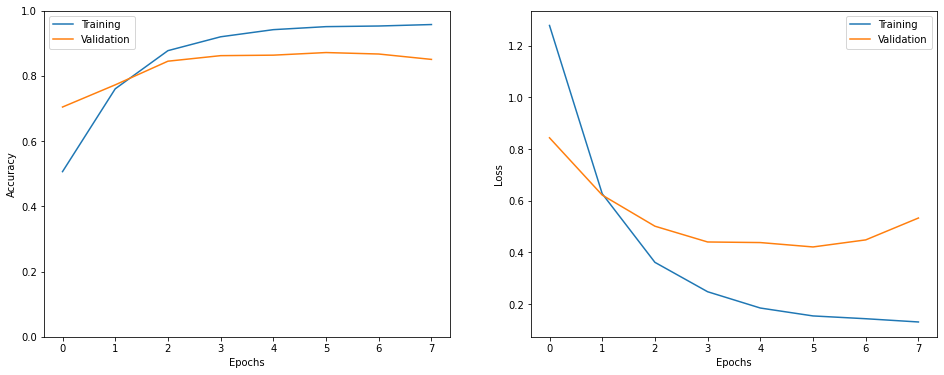

In [ ]:
show_history(h)

In [ ]:
i=random.randint(0,len(test)-1)
print('Sentence:',tweets_test[i])
print('Emotion :',index_to_class[test_labels[i]])

p=model.predict(np.expand_dims(padded_test_seq[i],axis=0))[0]
pred_class=index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion :',pred_class)

Sentence: i feel stressed but i love the feeling of the calming spirit of my heavenly father and the feeling to keep working
Emotion : sadness
Predicted Emotion : sadness


In [ ]:
pred=model.predict(padded_test_seq)

In [ ]:
pred

array([[9.9612576e-01, 3.1078737e-03, 4.4931073e-04, 3.0917610e-04,
        3.2253299e-06, 4.6794335e-06],
       [9.9619389e-01, 2.8743786e-03, 5.2918709e-04, 3.8546108e-04,
        7.5582702e-06, 9.5364785e-06],
       [9.9654359e-01, 2.7131350e-03, 3.0440243e-04, 4.2362406e-04,
        6.1494784e-06, 9.1325910e-06],
       ...,
       [4.4515869e-03, 9.8152554e-01, 1.0082837e-02, 2.4718156e-03,
        1.0263521e-03, 4.4193107e-04],
       [2.4187945e-02, 2.9849368e-03, 9.7075057e-01, 1.8776557e-04,
        2.5969959e-04, 1.6290052e-03],
       [3.7162695e-03, 1.8308457e-02, 1.0445797e-03, 6.0043228e-01,
        3.7045118e-01, 6.0472321e-03]], dtype=float32)